# Лабораторная работа
## Ранжирование с помощью ML


![](https://avatars.mds.yandex.net/get-research/1677227/2a00000168a82fc9b0eac19e430b8454a656/orig)


Одна из отличительных особенностей задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса, т.е. важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно других документов.

### Подходы к решению задачи ранжирования
Существуют 3 основных подхода к ранжированию, различие между которыми заключается в том, на какую функцию потерь они опираются:
  
1. **Поточечный подход (pointwise)**. В этом подходе предполагается, что каждой паре запрос-документ поставлена в соответствие численная оценка. Задача обучения ранжированию сводится к построению регрессии: для каждой отдельной пары запрос-документ необходимо предсказать её оценку.

2. **Попарный подход (pairwise)**. В таком подходе обучение ранжированию сводится к построению бинарного классификатора, которому на вход поступают два документа, соответствующих одному и тому же запросу, и требуется определить, какой из них лучше. Другими словами, функция потерь штрафует модель, если отранжированная этой моделью пара документов оказалась в неправильном порядке.

3. **Списочный подход (listwise)**. Его суть заключается в построении модели, на вход которой поступают сразу все документы, соответствующие запросу, а на выходе получается их перестановка.


Будем использовать самый простой подход - поточечный.

### Оценка качества

Для оценивания качества ранжирования найденных документов в поиске традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.

Для одного запроса DCG считается следующим образом:
$$ DCG(Q) = \sum_{i=1}^{numpos}\frac{(2^{rel_i} - 1)}{\log_2(i+1)}, $$
где
>$numpos$ — количество документов в поисковой выдаче, среди которых мы оценимваем качество (например, в предудыщих заданиях *num_pos* был равен 5)  
$rel_i$ — оценка релевантности документа, находящегося на i-той позиции   
   

Нормализованный вариант *nDCG* получается делением *DCG* на максимальное из его значений:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1].$$
> *IDCG* — наибольшее из возможных значение *DCG* 






Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$) размера $N$, необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q).$$

Пример реализации метрик ранжирование на python можно найти [здесь](https://gist.github.com/mblondel/7337391).

# Погнали
###  **Задача: предсказать оценку релевантности для запросов тестового датасета**


Мы будем работать на данных с конкурса [Интернет-математика 2009](https://academy.yandex.ru/events/data_analysis/grant2009/). По ссылке можно прочитать описание данных.      

Данные
> Данные разбиты на две выборки – обучающая выборка imat2009_learning.txt с известными оценками близости запроса и документа и тестовая выборка с неизвестными близостями imat2009_test.txt  

Обучающая выборка
> Данные для обучения содержат **97 290 строк**, которые соответствуют **9 124 запросам**  
Каждая строка соответствует паре «запрос-документ»    

Признаки
>Каждой паре «запрос-документ» соответствуют значения **245 признаков**. Формат хранения feat_num:value. Если значение признака равно 0, то он опускается.     
В комментариях в конце каждой строки указан **идентификатор запроса**.   
Файл с обучающей выборкой содержит **оценку релевантности**, значения из диапазона **[0, 4]** (4 – «высокая релевантность», 0 – «нерелевантно»).   


### DATA

In [40]:
# LOAD TRAIN DATA
file_learning = 'imat2009-datasets/imat2009_learning.txt'

# РЕП ОТКАЗАЛСЯ КУШАТЬ ДАТУ! 

with open(file_learning) as f:
    train_data = f.readlines()
    
    
# LOAD TEST DATA
file_test = 'imat2009-datasets/imat2009_test.txt'

with open(file_test) as f:
    test_data = f.readlines()


In [41]:
len(train_data), len(test_data)

(97290, 115643)

Структура данных следующая - первый элемент в строке - это оценка близости запроса и документа, дальше идут признаки документа, а последний элемент строки - это id запроса:

> RELEVANCE      feature:value feature:value ... feature:value     # QUERY_ID

In [15]:
train_data[0]

'1 1:0.000023 7:0.704953 8:0.550315 9:0.032294 11:0.712631 14:0.015686 15:0.137255 16:0.302576 17:1.000000 18:0.996078 22:1.000000 23:1.000000 24:1.000000 27:0.700000 28:0.587629 29:0.999881 30:0.032294 34:0.000023 36:0.431373 37:0.002247 38:0.054902 41:1.000000 46:0.002247 50:0.032294 51:0.325613 52:0.056641 53:0.820677 54:0.388235 55:0.450980 56:0.312547 57:0.004672 59:1.000000 61:0.000023 65:1.000000 68:0.712195 69:0.001400 70:1.000000 71:0.001013 73:0.709459 74:0.560784 76:0.142857 77:0.360800 78:1.000000 79:1.000000 80:1.000000 82:0.000023 83:1.000000 85:0.996078 86:0.070588 87:1.000000 88:0.999797 92:1.000000 93:0.714286 95:0.039216 97:0.000023 98:0.356490 99:0.165041 102:1.000000 103:1.000000 104:1.000000 105:0.486275 108:0.152941 120:0.996078 121:0.676507 122:0.032294 126:0.712980 128:0.121569 129:0.609261 132:1.000000 134:0.109804 135:0.030535 140:0.002247 142:0.698039 144:0.248111 145:0.356490 146:1.000000 147:0.498039 148:0.125490 150:0.704953 151:1.000000 152:0.098039 154:0

В test_data все оценки релевантности скрыты, поскольку этот набор данных использовался для проверки качества работы алгоритма в конкурсе. Нам эти данные не нужны, дальше работаем только с **train_data**.

Для проверки качества будущей модели надо разбить обучающую выборку на обучение и валидацию в соотношении 70 / 30

Внимание: разбивать необходимо **множество запросов QUERY_ID**, а не строчки датасета, чтобы в выборке находилась вся информация по запросу

Для этого вам надо:
1. собрать все запросы для каждого QUERY_ID

```
{
query_id : [
    RELEVANCE feature:value ... feature:value,
    ...
],
...
}
```

При этом я бы сразу собирала не сами данные, а номер строки в матрице данных
```
{
query_id : [
    line_num, line_num, ... line_num
],
...
}
```
2. собрать матрицу данных, размер вектора равен числу признаков = 245
```
data = np.zeros((len(train_data), feats_num), dtype=np.float32) 
```

3. собрать вектор с оценками релевантности, его размер равен размеру train_data

In [42]:
import numpy as np
from collections import defaultdict
from math import floor

labels = [] 
queries_lines_info = defaultdict(list) 

#train_data = train_data[:100]
data = np.zeros((len(train_data), 245), dtype=np.float32) 


#YOUR CODE HERE
for i, line in enumerate(train_data):
    line_data = line.split(' ')
    
    label = floor(float(line_data[0])) #если так не делать, то из-за всяких полтора часть метрик выдаёт ошибку
    query_id = int(line_data[-1])
    
    labels.append(label)
    queries_lines_info[query_id].append(i)
    
    for feat_data in line_data[1:-2]:
        feat_id, feat_value = feat_data.split(':')
        feat_id = int(feat_id)-1
        
        data[i, feat_id] = feat_value


In [5]:
queries_lines_info

defaultdict(list,
            {3382: [0, 1, 2, 3, 4, 5, 6],
             11800: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             21991: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
             19719: [33, 34, 35, 36],
             11542: [37, 38, 39, 40, 41],
             11546: [42, 43],
             11547: [44, 45, 46, 47, 48, 49],
             11544: [50,
              51,
              52,
              53,
              54,
              55,
              56,
              57,
              58,
              59,
              60,
              61,
              62,
              63,
              64,
              65],
             14472: [66, 67, 68, 69, 70, 71, 72, 73],
             8090: [74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86],
             11549: [87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98],
             3483: [99]})

In [43]:
# check
assert data.shape == (len(train_data), 245)
assert len(queries_lines_info.keys()) == 9124
assert len(labels) == len(train_data)

Разделим запросы из *queries_lines_info.keys()* на обучающую *train_queries_ids* и валидационную выборки *test_queries_ids* (70/30)

In [44]:
from sklearn.model_selection import train_test_split

#YOUR CODE HERE
queries_ids = list(queries_lines_info.keys())
train_queries_ids, test_queries_ids = train_test_split(queries_ids, test_size=0.3, random_state=23)

In [45]:
# check
assert len(train_queries_ids) / (len(train_queries_ids) + len(test_queries_ids)) == 0.6999123191582639

 > Теперь у нас есть:  
 1) айдишники запросов для обучения и валидации **queries_id_train, queries_id_test**   
 2) матрица данных **data**   
 3) словарь **queries** с информацией о том, какие строчки в этой матрице соответствуют какому айдишнику  
 
 С помощью этих данных разделите матрицу data на матрицы **X_train, y_train, X_test, y_test**

In [46]:
# разбиваем номера строк исходной матрицы на train и test

train_queries_lines_info = []
test_queries_lines_info = []

for query_id in train_queries_ids:
    train_queries_lines_info += queries_lines_info[query_id]
    
for query_id in test_queries_ids:
    test_queries_lines_info += queries_lines_info[query_id]
    
labels = np.array(labels)

X_train, y_train = data[train_queries_lines_info], labels[train_queries_lines_info]
X_test, y_test = data[test_queries_lines_info], labels[test_queries_lines_info]

In [47]:
train_queries_lines_info = np.array(train_queries_lines_info)
test_queries_lines_info = np.array(test_queries_lines_info)

Поздравляю, если вы все сделали до этого моменты, вы восхитительны! 

Данные готовы, можно заряжать модели                                                           
Для оценивания качества моделей используйте метрику nDCG, реализованную ниже

In [30]:
import metrics

def get_nDCG_score(queries, queries_lines_info, test_queries_lines_info, labels_true, labels_predicted):
    nDCG_scores = [] # nDCG по каждому запросу
    
    for query in queries:
        
        query_lines = queries_lines_info[query]
        query_lines_in_testdata = [np.where(test_queries_lines_info==line)[0][0] for line in query_lines]
        
        query_labels_true = labels[query_lines]
        query_labels_pred = labels_predicted[query_lines_in_testdata]
        
        nDCG = metrics.ndcg_score(query_labels_true, query_labels_pred, k=10)
        nDCG_scores.append(nDCG)
        
    nDCG_Queries = np.sum(nDCG_scores) / len(queries) # усредняем по всем запросам
    return nDCG_Queries


### FIT PREDICT

Воспользовавшись известными вам техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора

``` from sklearn.linear_model import LinearRegression``` 

In [79]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

lin_reg_y_pred = lin_reg.predict(X_test)

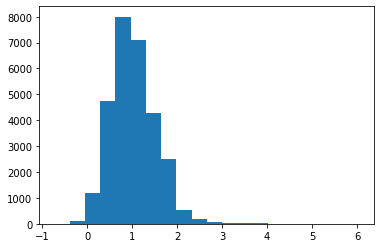

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

h = plt.hist(lin_reg_y_pred, bins=20)

Посчитаем качество модели по метрике **nDCG**

In [81]:
score_lin_reg = get_nDCG_score(
    queries =  test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_reg_y_pred
)

score_lin_reg

0.8273441577972347

Давайте теперь решим эту задачу не как регрессию, а как классификацию

In [82]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC(max_iter = 100000)
lin_svc.fit(X_train, y_train)

lin_svc_pred = lin_svc.predict(X_test)

In [83]:
score_svc_pred = get_nDCG_score(
    queries =  test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = lin_svc_pred
)

score_svc_pred

0.7851228182167391

#### Ранжируем с RandomForestRegressor

In [84]:
from sklearn.ensemble import RandomForestRegressor

rand_tree = RandomForestRegressor()
rand_tree.fit(X_train, y_train)

rand_tree_predict = rand_tree.predict(X_test)


C:\Users\asus\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [85]:
score_rand_tree = get_nDCG_score(
    queries =  test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = rand_tree_predict
)

score_rand_tree

0.8208874938408885

#### Ранжируем с XGBoost

In [86]:
#!pip install xgboost
from xgboost import XGBClassifier

x = XGBClassifier()
x.fit(X_train, y_train)

x_predict = x.predict(X_test)



In [87]:
score_x = get_nDCG_score(
    queries =  test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = x_predict
)

score_x

0.7907175025324406

#### Ранжируем с LightGBM

In [88]:
#!pip install lightgbm
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
lgb_bst = lgb.train({}, train_data)
lightgbm_y_pred = lgb_bst.predict(X_test)

In [89]:
score_lgb = get_nDCG_score(
    queries =  test_queries_ids, 
    queries_lines_info = queries_lines_info, 
    test_queries_lines_info = test_queries_lines_info, 
    labels_true = y_test, 
    labels_predicted = rand_tree_predict
)

score_lgb

0.8208874938408885

Удивительным образом, решить задачу классификации как задачу регрессии дало наиболее высокий результат из всех имеющихся